In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
import numpy as np
from scipy.stats import zscore
from joblib import load
import sys, os
from scipy.io import savemat
from pathlib import Path

In [84]:

folder = 'C:\\Users\\mvalero\\OneDrive - imim.es\\Documents\\Code\\HippoCookBook\\utilities\\python\\'
fnames = ['wave_ripple_mean', 'wave_theta_mean'] # Filenames (without␣ extension) to load
# --- Load waveform data from .mat files ---
data = {}
for fname in fnames:
    path = f'{folder}{fname}.mat'
    data_ = loadmat(path)[fname] # Load MATLAB variable from file
    # Use 'sw' for ripple-related data, and 'theta' otherwise
    key = 'sw' if 'ripple' in fname else 'theta'
    data[key] = data_

# --- Adjust ripple waveform shape ---
# For ripple ('sw') waveforms, pad one sample at the beginning and end
# This ensures a total of 629 samples, matching downstream expectations
data['sw'] = np.hstack((
                    data['sw'][:, 0][:, None], # Repeat first sample
                    data['sw'], # Original waveform
                    data['sw'][:, -1][:, None] # Repeat l
    ))

# --- Z-score each waveform ---
for key in data.keys():
    data[key] = zscore(data[key], axis=1)

In [85]:
# --- Load embedding models ---
path = 'C:\\Users\\mvalero\\OneDrive - imim.es\\Documents\\Code\\Hipp-LFP-embedding'
sys.path.append(os.path.abspath(path))
from hipp_embedding import embedding, trajectory
# Load PCA and Isomap models previously saved using joblib
pca_model = load(f'{path}/models/pca')
embedding_model = load(f'{path}/models/iso')
# --- Project the z-scored waveforms into the low-dimensional embedding space␣
projections = embedding.project(data, pca_model, embedding_model)

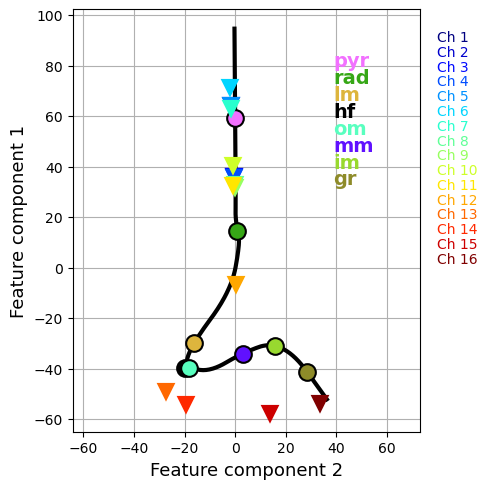

In [86]:
# --- Build the reference trajectory and project control points ---
train_data_path = f'{path}/data/trajectory_points.npz'
traj, ctrlpts_proj, ctrlpts_labels = trajectory.define_trajectory(pca_model,embedding_model, input_data=train_data_path)
# --- Identify control points corresponding to true anatomical layers ---
# Ignore interpolated points by filtering out labels that contain '_interp'
layeris = [i for i, label in enumerate(ctrlpts_labels) if '_interp' not in label]
layer_labels = [ctrlpts_labels[i] for i in layeris]
# --- Compute the mean projection across mice for each layer ---
meanproj_layer = np.nanmean(ctrlpts_proj, axis=0)
# --- Define a unique RGB color for each anatomical layer ---
layer_colors = {
                'pyr': np.array([0.949, 0.439, 1.000]),
                'rad': np.array([0.212, 0.655, 0.086]),
                'lm' : np.array([0.867, 0.710, 0.239]),
                'hf' : np.array([0.000, 0.000, 0.000]),
                'om' : np.array([0.349, 1.000, 0.749]),
                'mm' : np.array([0.376, 0.067, 1.000]),
                'im' : np.array([0.596, 0.851, 0.184]),
                'gr' : np.array([0.557, 0.545, 0.161])
                }
# --- Start plotting ---
plt.figure(figsize=(5, 5))
# Plot the full (interpolated) trajectory as a black curve
plt.plot(traj[:, 1], traj[:, 0], color='k', lw=3)

# Plot the mean projection point for each anatomical layer
for i in layeris:
    label = ctrlpts_labels[i]
    color = layer_colors[label]
    plt.plot(meanproj_layer[i, 1], meanproj_layer[i, 0],
            marker='o', linestyle='none',
            markerfacecolor=color, markeredgecolor='black',
            markeredgewidth=1.5, markersize=12)
# --- Plot projections from new data ---
# Assign a different colormap color to each waveform
cmap = plt.cm.jet
colors = cmap(np.linspace(0, 1, len(projections)))
for chi, proj_ in enumerate(projections):
    plt.plot(proj_[1], proj_[0],
            'v', mew=3, markersize=8,
            color=colors[chi],
            label=f'Ch {chi+1}')
# --- Add text labels for anatomical layers (color-coded) ---
for i, label in enumerate(layer_labels):
    plt.text(
            0.75, 0.9 - i * 0.04,
            label,
            transform=plt.gca().transAxes,
            fontsize=14,
            fontweight='bold',
            color=layer_colors[label],
            verticalalignment='top'
            )
# --- Add text legend for channel markers ---
for chi in range(len(projections)):
    plt.text(
            1.05, 0.95 - chi * 0.035,
            f'Ch {chi+1}',
            transform=plt.gca().transAxes,
            fontsize=10,
            color=colors[chi],
            verticalalignment='top'
            )
# --- Final plot formatting ---
plt.grid(True)
plt.axis('equal')
plt.xlabel('Feature component 2', fontsize=13)
plt.ylabel('Feature component 1', fontsize=13)
plt.tight_layout()

In [87]:
# --- Defining the 2D Trajectory Corresponding to the Anatomical Radial Axis ---
# To compute the low-dimensional trajectory that maps the anatomical radial axis
# spanning CA1 to DG, we use the function below. This function processes reference
# data recorded from six mice with probes spanning this axis, and returns:
# - traj: a (n_points x 2) array representing the 2D trajectory in feature space,
# - ctrlpts_proj: projections of labeled control points along the trajectory,
# - ctrlpts_labels: anatomical labels associated with each control point.

train_data_path = f'{path}/data/trajectory_points.npz'
traj, ctrlpts_proj, ctrlpts_labels = trajectory.define_trajectory(
    pca_model,
    embedding_model,
    input_data=train_data_path
)
# The variable `traj` contains the smooth trajectory plotted as a black line
# in the previous figure. Each row corresponds to a coordinate in the 2D embedding
# space, and the trajectory is ordered along the radial axis from superficial CA1
# layers through to the dentate gyrus.

In [88]:
# --- Mapping Points to Their Linearized Trajectory Coordinates ---
# To estimate the 1D (linearized) coordinate of each data point along the 2D anatomical
# trajectory, we assign each point to its nearest position on the trajectory curve.
# This allows us to quantify the location of a waveform or channel along the radial
# CA1–DG axis in consistent units.
# As an example, we compute the linearized trajectory coordinate of the control points
# labeled as belonging to the pyramidal (pyr) layer. This will help us later calibrate
# the coordinate system.
precision = 2 # Same precision used when defining the trajectory; ensures consistent scaling
pyr_trajis = np.zeros((len(ctrlpts_proj)))
for proji, proj_ in enumerate(ctrlpts_proj[:, 0]):
    # Find the index of the closest trajectory point to each control point
    traji = np.argmin(np.sum((proj_ - traj)**2, axis=1))
    pyr_trajis[proji] = traji
    # The `offset` below represents the average position of the pyramidal layer channels
    # along the linearized trajectory. This will later serve as a reference point
    # for interpreting other projections.
offset = np.mean(pyr_trajis / precision)

In [89]:
# --- Projecting Experimental Channels onto the Linearized Trajectory ---
# We now compute the position of each of our experimental channels (waveform projections)
# along the linearized anatomical trajectory. This allows us to compare their anatomical
# location relative to the training dataset.
trajis = np.zeros((len(projections)))
for proji, proj_ in enumerate(projections):
    # Find the closest point along the 2D trajectory
    traji = np.argmin(np.sum((proj_ - traj)**2, axis=1))
    trajis[proji] = traji
# Convert to the same scale as before by dividing by precision,
# and align relative to the pyramidal layer reference offset.
trajis = trajis / precision - offset

# After this transformation, a value of 0 corresponds to a channel located
# at the average position as the training pyramidal layer channels.

In [90]:
# --- Defining Deep vs. Superficial CA1 Pyramidal Layer Channels ---
# To distinguish between deep and superficial CA1 pyramidal cells, you can choose
# between two strategies depending on your dataset and preference:
# Option 1: Use the pre-defined threshold from the reference dataset
# According to my data (Figure 5B, Lopes-dos-Santos et al. 2025) pyramidal layer channels
# with a linearized trajectory value < 5.5 can be classified as 'deep',
# while those with values > 5.5 are considered 'superficial'.
# Option 2: If you'd prefer to tailor the classification to your own data,
# follow these steps:
# - Identify the pyramidal layer channels in your dataset.
# - Compute their linearized trajectory coordinates as described earlier.
# - Plot a histogram of these values to visualize their distribution (across all recs, all mice)
# I believe you’ll see a bimodal distribution (as in my Figure 5B).
# This arises because tiny anatomical displacements near the pyramidal layer center
# result in large shifts in feature space (see Discussion in the paper for more on this).
# - Fit a Gaussian Mixture Model (GMM) with two components to this distribution.
# - Use the intersection point of the two Gaussians as your dataset-specific
# threshold for classifying channels as deep or superficial.
# (This is effectively what a GMM-based classifier would do.)

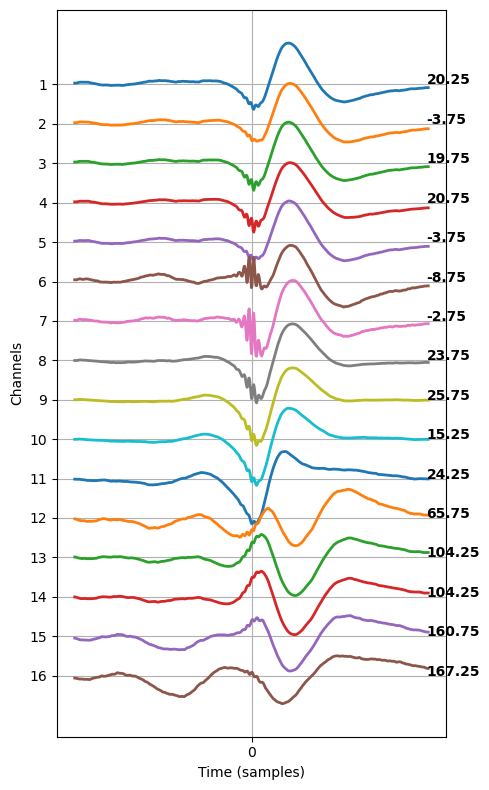

In [91]:
# --- Visualizing Ripple Waveforms and Their Linearized Anatomical Coordinates␣
plt.figure(figsize=(5, 8))
_plotoffsets = []
# Plot each ripple waveform with a vertical offset and annotate with its linearized trajectory coordinate
for chi, lfp in enumerate(data['sw']):
    offset = 3
    plt.plot(lfp - chi * offset, lw=2) # Apply vertical offset for visualization
    _plotoffsets.append(-chi * offset)
    
    # Add the linearized coordinate as a label to the right of each waveform
    plt.text(625, -chi * offset, f'{trajis[chi]:.2f}', fontweight='bold')

# Set custom y-tick labels to indicate channel number
plt.yticks(_plotoffsets, 1 + np.arange(len(_plotoffsets)))

# Set x-tick at center of waveform
plt.xticks([len(lfp) / 2], [0])
plt.xlabel('Time (samples)')
plt.ylabel('Channels')
plt.grid(True)
plt.tight_layout()

In [93]:
# Save data
p = Path(folder)
folder_name = p.name
filename = f"{folder_name}.lfp_embedding.channelinfo.mat"

lfp_embeding = {
    'data_projection_1d': trajis.T,
    'data_projection_2d': projections,
    'model_trajectory': traj,
    'training_data_points': meanproj_layer[layeris],
    'training_data_labels': layer_labels,
    'all_training_data_points': meanproj_layer,
    'all_training_data_labels': ctrlpts_labels,
    'precision': precision,
}

savemat(filename, {'lfp_embeding': lfp_embeding})